# Import libs

In [1]:
import pandas as pd
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import sys

sys.path.append('..')
from eFlow.ClusterMaster import *
from eFlow.DataFrameTypes import *
from eFlow.Analysis.DataAnalysis import *
from eFlow.PipelineSegments.DataCleaner import *
from xgboost import XGBClassifier
import ipython_blocking
from pivottablejs import pivot_ui
import scikitplot as skplt

In [2]:
%matplotlib notebook
%matplotlib inline

### Be sure to run the following

## Declare Worflow Variables

#### (This should be the only place you should have to declare anything)

In [3]:
dataset_path = "Datasets/titanic_train.csv"
target_column = "Survived"
parent_project_name = "Pre processing"
prediction_method = "Classification"
notebook_mode = True

# Import dataset

In [4]:
df = pd.read_csv(dataset_path)
display(df.shape)
df.head()

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Interaction tool for dataframes

### Explore the data

In [5]:
pivot_ui(df,
         outfile_path='Piviot_Table_JS.html')

In [6]:
# w = widgets.SelectMultiple(
#     options=['Apples', 'Oranges', 'Pears'],
#     value=['Oranges'],
#     #rows=10,
#     description='Fruits',
#     disabled=False
# )
# del w

In [7]:
a = str(u"\u2192")
print(a)

→


## Remove Un-Wanted Columns

### Do not remove nans yet, let the datacleaner do it's job

In [8]:
df.drop(columns=["Name",
                 "Ticket",
                 "PassengerId"],
        inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [9]:
from dateutil import parser
dt = parser.parse("Aug 28 1999 12:00AM")

In [10]:
df["Date_test"] = ["2019-01-02" for _ in range(0,df.shape[0])]
df["Date_test"][0] = np.nan
# df["Date_test"] = [parser.parse(val)for val in df["Date_test"].value_counts().keys()]

/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Basic Feature manipulation

### Change cabin column to have the level on the ship

In [11]:
df["Cabin"] = df["Cabin"].str.replace(r'\d+', '').str[0]

## Change Feature Data types

### Look at data types

In [12]:
df.dtypes

Survived       int64
Pclass         int64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Cabin         object
Embarked      object
Date_test     object
dtype: object

### Make given data type changes

In [13]:
# df["Pclass"] = df["Pclass"].replace(1, np.nan)

### Final look at data types

In [14]:
df.dtypes

Survived       int64
Pclass         int64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Cabin         object
Embarked      object
Date_test     object
dtype: object

## Set up DataFrameTypes

In [15]:
df_features = DataFrameTypes(df,
                             target_column=target_column,
                             ignore_nulls=True)

Categorical Features: {'Cabin', 'Sex', 'Embarked'}

Possible One hot encoded feature names: {'Cabin': ['Cabin_D', 'Cabin_A', 'Cabin_T', 'Cabin_E', 'Cabin_G', 'Cabin_B', 'Cabin_F', 'Cabin_C'], 'Sex': ['Sex_female', 'Sex_male'], 'Embarked': ['Embarked_S', 'Embarked_C', 'Embarked_Q']}

------------------------------------------------------------------------------------------
Numerical Features: {'Survived', 'Pclass', 'SibSp', 'Age', 'Parch', 'Fare'}

Integer Features: {'Survived', 'Pclass', 'SibSp', 'Parch'}

Float Features: {'Fare', 'Age'}

Datetime Features: {'Date_test'}

Target Feature: Survived



## Skim through Value Counts

In [16]:
for col in df.columns:
    if col not in df_features.get_float_features() and len(np.unique(df[col].dropna().values)) <= 12:
        display(df[col].value_counts())
        print("***" * 4 + "\n\n")

0    549
1    342
Name: Survived, dtype: int64

************




3    491
1    216
2    184
Name: Pclass, dtype: int64

************




male      577
female    314
Name: Sex, dtype: int64

************




0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

************




0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

************




C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

************




S    644
C    168
Q     77
Name: Embarked, dtype: int64

************




2019-01-02    890
Name: Date_test, dtype: int64

************




### Perform quick analysis

In [17]:
# analysis_obj = DataAnalysis(df,
#                             df_features,
#                             project_name=f'{parent_project_name}/General Analysis (Before Cleaning)',
#                             missing_data_visuals=False)

## Data Cleaning

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Date_test,1,0.1


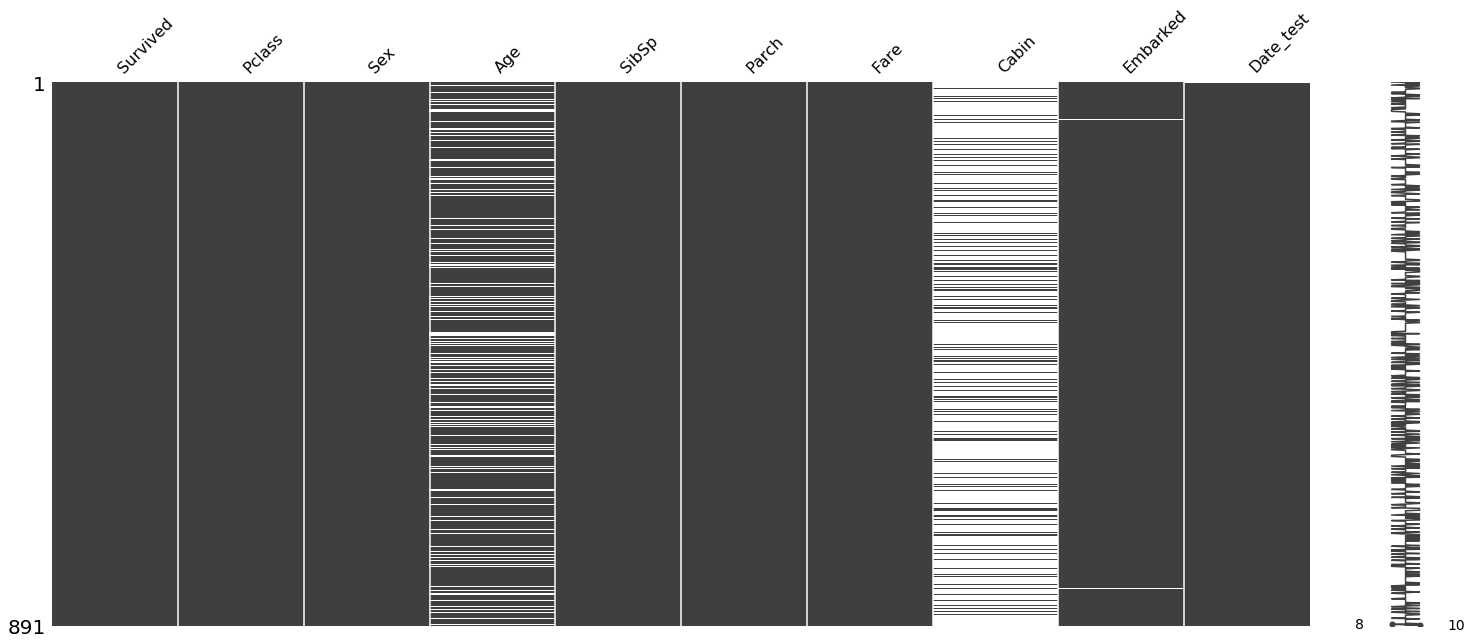

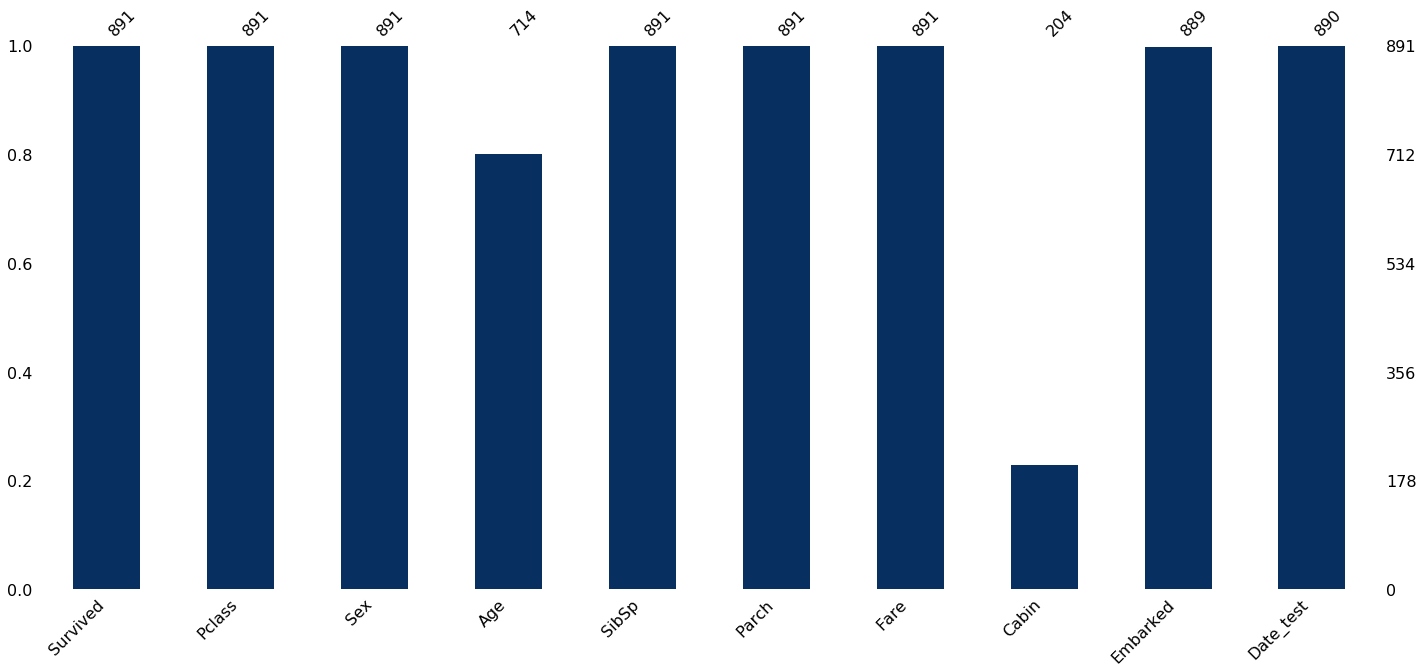

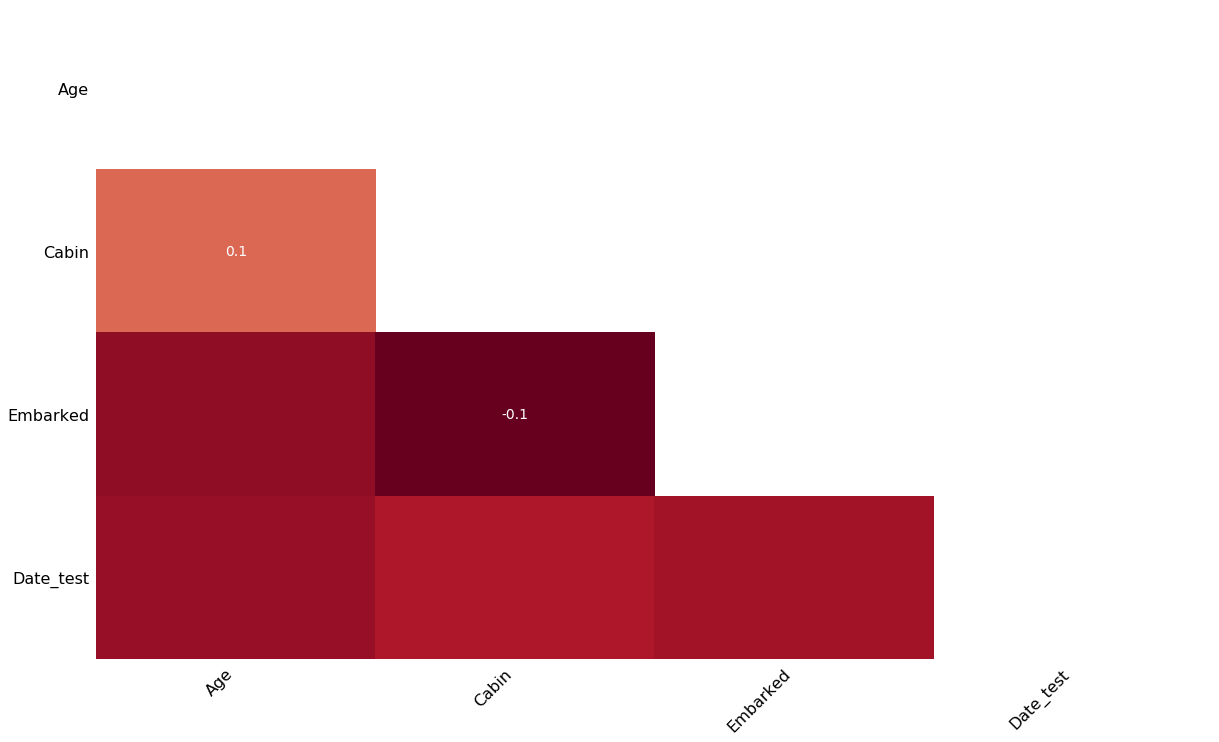

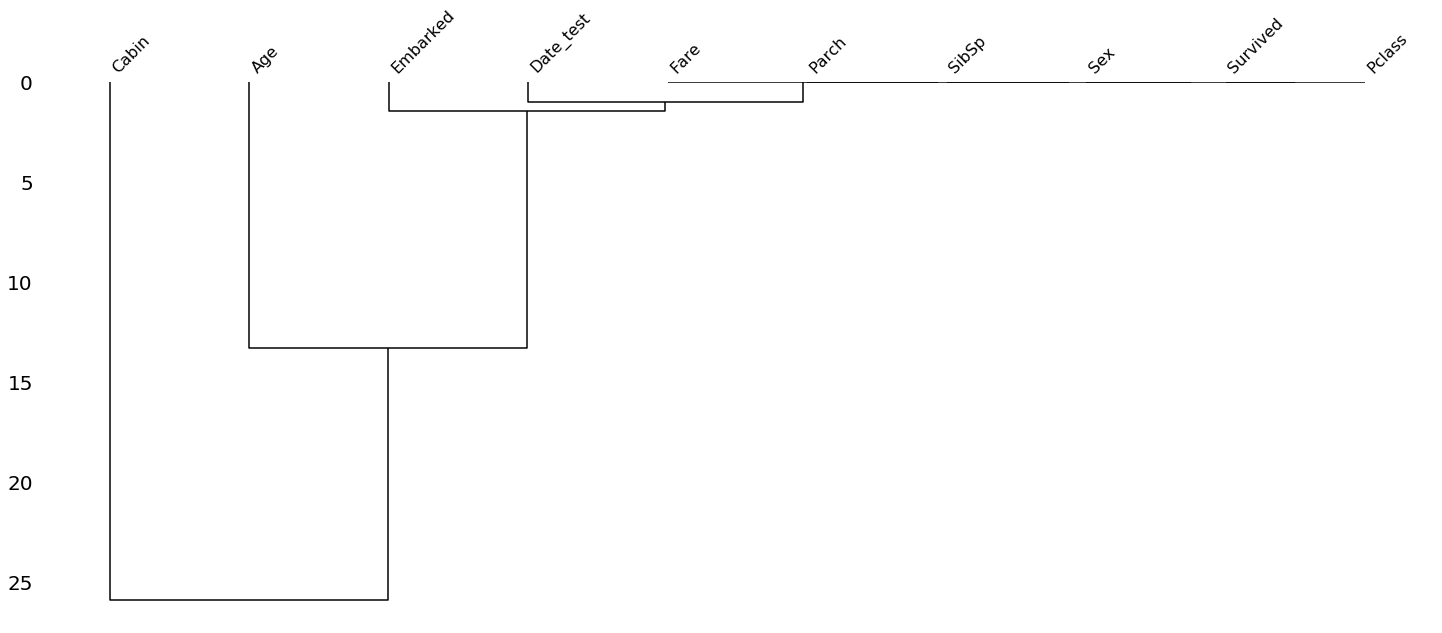

In [18]:
data_cleaner = DataCleaner(df,
                           project_name=f'{parent_project_name}/Data Cleaning',
                           missing_data_visuals=True)

In [19]:
data_cleaner.data_cleaning_widget(df,
                                  df_features)

Text(value='Default Data Cleaning', description='File Name:', layout=Layout(left='590px'), placeholder='Replac…

interactive(children=(Select(description='Features', layout=Layout(height='175px', width='50%'), options=('Age…

Button(description='Create JSON File from options', layout=Layout(bottom='5px', left='100px', width='40%'), st…

In [20]:
data_cleaner.get_last_saved_json_file_path()

AttributeError: 'DataCleaner' object has no attribute 'get_last_saved_json_file_path'

In [ ]:
data_cleaner.data_cleaning_with_json_file(df,
                                          data_cleaner.get_last_saved_json_file_path())

In [ ]:
from impyute.imputation.cs import mice

a = df["Age"].tolist()
# start the MICE training
imputed_training=mice(df.values)

In [21]:
import datawig

df_train, df_test = datawig.utils.random_split(df)

#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin','Embarked'], # column(s) containing information about the column we want to impute
    output_column= 'Age', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Fit an imputer model on the train data
imputer.fit(train_df=df, num_epochs=200)

2019-08-30 14:30:03,717 [INFO]  
========== start: fit model
2019-08-30 14:30:03,718 [WARNING]  Already bound, ignoring bind()
2019-08-30 14:30:03,823 [INFO]  Epoch[0] Batch [0-26]	Speed: 4484.99 samples/sec	cross-entropy=15.338296	Age-accuracy=0.000000
2019-08-30 14:30:03,904 [INFO]  Epoch[0] Train-cross-entropy=13.964325
2019-08-30 14:30:03,905 [INFO]  Epoch[0] Train-Age-accuracy=0.000000
2019-08-30 14:30:03,906 [INFO]  Epoch[0] Time cost=0.186
2019-08-30 14:30:03,910 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-08-30 14:30:03,926 [INFO]  Epoch[0] Validation-cross-entropy=16.319540
2019-08-30 14:30:03,926 [INFO]  Epoch[0] Validation-Age-accuracy=0.000000
2019-08-30 14:30:04,023 [INFO]  Epoch[1] Batch [0-26]	Speed: 4526.87 samples/sec	cross-entropy=14.560543	Age-accuracy=0.000000
2019-08-30 14:30:04,103 [INFO]  Epoch[1] Train-cross-entropy=13.553460
2019-08-30 14:30:04,104 [INFO]  Epoch[1] Train-Age-accuracy=0.000000
2019-08-30 14:30:04,105 [INFO]  Epoch[1] Time 

In [22]:
imputed_training=mice(df[df_features.get_numerical_features()].values)

NameError: name 'mice' is not defined

In [ ]:
# !pip install datawig
# !pip install opencv-python
# !pip install Pillow
# !pip install tesserocr

In [27]:
import random

df["Cabin"] = df["Cabin"].fillna("A")
test = df.drop(columns=["Date_test", "Embarked"]).dropna()

test["Cabin"] = df["Cabin"] == "B"
test["Sex"] = df["Sex"] == "male"
test[target_column] = [random.randint(0, 5) for _ in range(0,test.shape[0])]
print(len(test[target_column]))

y = test[target_column].values
X = test.values

print(X.shape)
print(y.shape)


df_features = DataFrameTypes(test,
                             target_column=target_column,
                             ignore_nulls=True) 
df_features.get_all_features()

714
(714, 8)
(714,)
Bool Features: {'Cabin', 'Sex'}

------------------------------------------------------------------------------------------
Numerical Features: {'Survived', 'Pclass', 'SibSp', 'Age', 'Parch', 'Fare'}

Integer Features: {'Survived', 'Pclass', 'SibSp', 'Parch'}

Float Features: {'Fare', 'Age'}

Target Feature: Survived



['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=517, stratify=y,
)

In [29]:
from sklearn.tree import DecisionTreeClassifier
from eFlow.ToolBox.Modeling import *
# Find best parameters for model
param_grid = {
    "max_depth": list(range(2, 3)),
    "min_samples_leaf": list(range(80, 130, 5)),
    "criterion": ["gini", "entropy"],
#     "n_splits": [20, 30]
}

model, best_params = optimize_model_grid(
    model=DecisionTreeClassifier(),
    X_train=X_train, y_train=y_train,
    param_grid=param_grid
)

Tuned Parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 80}
Best score on trained data was 0.699065


/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)




------------------------------Train data------------------------------


,Metric Scores (Train data)
Precision(micro),0.6991
Precision(macro),0.5123
Precision(weighted),0.5380
MCC,0.6742
Recall(micro),0.6991
Recall(macro),0.6667
Recall(weighted),0.6991
F1-Score(micro),0.6991
F1-Score(macro),0.5662
F1-Score(weighted),0.5942


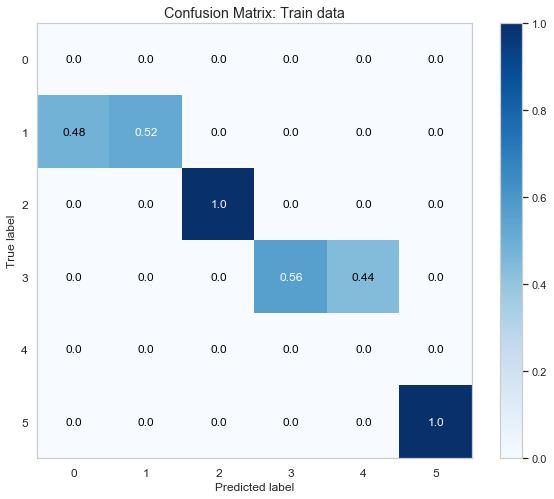



**********Generating graphs for model's correctly predicted...**********

Generating graph for Survived.
--------------------------------------------------------------------------------


Generating graph for Pclass.
--------------------------------------------------------------------------------


Generating graph for Sex.
--------------------------------------------------------------------------------


Generating graph for Age.
--------------------------------------------------------------------------------


Generating graph for SibSp.
--------------------------------------------------------------------------------


Generating graph for Parch.
--------------------------------------------------------------------------------


Generating graph for Fare.
--------------------------------------------------------------------------------


Generating graph for Cabin.
--------------------------------------------------------------------------------




**********Generating graphs for mod

/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1,2,3,4,5,accuracy,macro avg,weighted avg
f1-score,0.0,0.681159,1.0,0.715953,0.0,1.0,0.699065,0.566185,0.594199
precision,0.0,0.516484,1.0,0.557576,0.0,1.0,0.699065,0.512343,0.538031
recall,0.0,1.000000,1.0,1.000000,0.0,1.0,0.699065,0.666667,0.699065
support,88.0,94.000000,94.0,92.000000,73.0,94.0,0.699065,535.000000,535.000000




------------------------------Test data------------------------------


,Metric Scores (Test data)
Precision(micro),0.7039
Precision(macro),0.5134
Precision(weighted),0.5444
MCC,0.6787
Recall(micro),0.7039
Recall(macro),0.6667
Recall(weighted),0.7039
F1-Score(micro),0.7039
F1-Score(macro),0.5671
F1-Score(weighted),0.6003


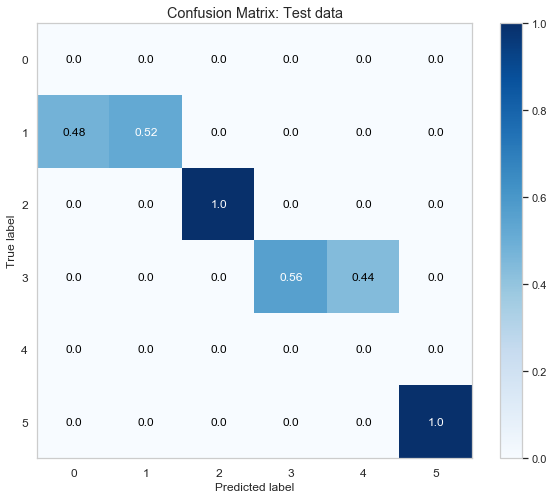



**********Generating graphs for model's correctly predicted...**********

Generating graph for Survived.
--------------------------------------------------------------------------------


Generating graph for Pclass.
--------------------------------------------------------------------------------


Generating graph for Sex.
--------------------------------------------------------------------------------


Generating graph for Age.
--------------------------------------------------------------------------------


Generating graph for SibSp.
--------------------------------------------------------------------------------


Generating graph for Parch.
--------------------------------------------------------------------------------


Generating graph for Fare.
--------------------------------------------------------------------------------


Generating graph for Cabin.
--------------------------------------------------------------------------------




**********Generating graphs for mod

/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1,2,3,4,5,accuracy,macro avg,weighted avg
f1-score,0.0,0.688172,1.0,0.714286,0.0,1.0,0.703911,0.567076,0.600280
precision,0.0,0.524590,1.0,0.555556,0.0,1.0,0.703911,0.513358,0.544433
recall,0.0,1.000000,1.0,1.000000,0.0,1.0,0.703911,0.666667,0.703911
support,29.0,32.000000,32.0,30.000000,24.0,32.0,0.703911,179.000000,179.000000


In [30]:
from eFlow.Analysis.SupervisedModelAnalysis import *

SupervisedModelAnalysis(model=model,
                        pred_func=model.predict,
                        model_name=repr(model).split("(")[0],
                        X_train=X_train,
                        X_test=X_test,
                        y_train=y_train,
                        y_test=y_test,
                        notebook_mode=True,
                        project_name=f'{parent_project_name}/Supervised Analysis',
                        prediction_type="Classification",
                        thresholds=[.05, .2, .1, .05, .9, .6],
                        df_features=df_features)